# Modelling - Part 4 - Predicting top10

In [1]:
#import libraries
import pandas as pd
import numpy as np
import collections
import re
import sys
import time
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from itertools import islice
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from functools import reduce

In [2]:
#load different datasets

In [3]:
# CUSTOM TEXT FEATURES
df_text=pd.read_pickle("df_add_feat")
X_text=df_text[['polysyl_count','difficult_count','count_rhyming_words']]

In [4]:
# TOP 1000 TFIDF FEATURES

In [5]:
X_tfidf=pd.read_pickle("df_tfidf")

In [6]:
#MUSIC FEATURES
music_features=['danceability', 'key', 'loudness','energy','acousticness', 'speechiness', 'mode', 'instrumentalness', 'liveness','valence', 'tempo']
X_music=df_text[music_features]
X_music=X_music.fillna(X_music.mean())

In [7]:
#save labels: ranking<10=1, 0 otherwise
y=pd.cut(df_text.Rank,bins=[0,10,100],labels=[1,0])

In [8]:
# dataframe with word vectors

In [9]:
X_wv=pd.read_pickle("df_wordvec")

In [10]:
X_wv.shape

(4831, 300)

In [11]:
X_text.shape

(4831, 3)

In [12]:
X_music.shape

(4831, 11)

In [13]:
X_tfidf.shape

(4831, 1000)

In [14]:
#make one df of tfidf plus w2v features

X_alltext=X_tfidf.merge(X_wv, how='left', left_index=True, right_index=True)

In [15]:
X_alltext.shape

(4831, 1300)

In [16]:
#one df of all text features plus music features
X_all=X_alltext.merge(X_music, how='left', left_index=True, right_index=True)

In [17]:
X_all.shape

(4831, 1311)

## 5. Build models

#### Logistic regression

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression

In [19]:
#define parameter grid for logistic cv

C = [0.00001,0.0001, 0.001, 0.01, 0.1,1,10,100,1000, 10000]
penalty = ['l2']

parameters = dict(C=C, penalty=penalty)

In [20]:
def logistic_cv(X_train, X_test, y_train, y_test):
    logistic=LogisticRegression(class_weight='balanced', max_iter=500)
    gsl=GridSearchCV(logistic, parameters, cv=3, n_jobs=-1, scoring="roc_auc")
    gsl.fit(X_train, y_train)
    return gsl

In [21]:
#fit tuned model
def fit_tuned_lr_model(model):    
    logisticCV=LogisticRegression(class_weight='balanced',C=model.best_params_['C'], penalty=model.best_params_['penalty'], max_iter=1000)
    logisticCV.fit(X_train, y_train)

    #return predicted probabilities
    lr_probs = logisticCV.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    roc_auc=roc_auc_score(y_test, lr_probs)
    fpr, tpr, _ = roc_curve(y_test, lr_probs)
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)
    print("Fitted tuned logit  model ", roc_auc)
    return logisticCV,roc_auc, fpr, tpr

In [22]:
#Logistic Classifier on word2vec features 
X_train, X_test, y_train, y_test = train_test_split(X_wv,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)
#fit tuned model
lr_fit_wv=fit_tuned_lr_model(lr)
# save the tuned model to disk
filename = 'tuned_logistic_wv.sav'
pickle.dump(lr_fit_wv, open(filename, 'wb'))

tuned hyperparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
ROC AUC : 0.5209331961322169
Fitted tuned logit  model  0.5354615092172422


In [23]:
#Logistic Classifier on tfidf features 
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)
#fit tuned model
lr_fit_tfidf=fit_tuned_lr_model(lr)
# save the tuned model to disk
filename = 'tuned_logistic_tfidf.sav'
pickle.dump(lr_fit_tfidf, open(filename, 'wb'))

tuned hyperparameters :(best parameters)  {'C': 1, 'penalty': 'l2'}
ROC AUC : 0.5484162586215975
Fitted tuned logit  model  0.5132454884450808


In [24]:
#Logistic Classifier on all text features 
X_train, X_test, y_train, y_test = train_test_split(X_alltext,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)
#fit tuned model
lr_fit_alltext=fit_tuned_lr_model(lr)
# save the tuned model to disk
filename = 'tuned_logistic_alltext.sav'
pickle.dump(lr_fit_alltext, open(filename, 'wb'))

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


tuned hyperparameters :(best parameters)  {'C': 1000, 'penalty': 'l2'}
ROC AUC : 0.5267670188496282
Fitted tuned logit  model  0.5043679778689122


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [25]:
#Logistic Classifier on only music features 
X_train, X_test, y_train, y_test = train_test_split(X_music,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)
#fit tuned model
lr_fit_music=fit_tuned_lr_model(lr)
# save the tuned model to disk
filename = 'tuned_logistic_music.sav'
pickle.dump(lr_fit_music, open(filename, 'wb'))

tuned hyperparameters :(best parameters)  {'C': 10, 'penalty': 'l2'}
ROC AUC : 0.5587219235773967
Fitted tuned logit  model  0.5864414731409806


#### Random forest

In [26]:
#random forest model
#define parameter grid for randomized search with forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#n_estimators
n_estimators = [250,300, 350]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_estimators':n_estimators}

In [27]:
def rf_rs(X_train, X_test, y_train, y_test):

    #Instantiate the classifier
    rf=RandomForestClassifier(n_jobs=-1, class_weight='balanced')
    rs=RandomizedSearchCV(rf,random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
    rs.fit(X_train, y_train)
    return rs

In [28]:
# fit tuned model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def fit_tuned_rf_model(model):
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)

    modelCV=RandomForestClassifier(class_weight='balanced',max_features=model.best_params_['max_features'], max_depth=model.best_params_['max_depth'], min_samples_split=model.best_params_['min_samples_split'], min_samples_leaf=model.best_params_['min_samples_leaf'], bootstrap=model.best_params_['bootstrap'],n_estimators=model.best_params_['n_estimators'])
    modelCV.fit(X_train, y_train)

    #return predicted probabilities
    probs = modelCV.predict_proba(X_test)
        # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    roc_auc=roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    print("Fitted tuned random forest model ", roc_auc)
    return modelCV, roc_auc, fpr, tpr

In [29]:
#Random forest classifier on word2vec features
X_train, X_test, y_train, y_test = train_test_split(X_wv,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)
rf_fit_wv=fit_tuned_rf_model(rf)
# save the tuned model to disk
filename = 'tuned_rf_wv.sav'
pickle.dump(rf_fit_wv, open(filename, 'wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.0min finished


tuned hyperparameters :(best parameters)  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
ROC AUC : 0.5355143378445385
Fitted tuned random forest model  0.5230107500788662


In [30]:
#Random forest classifier on tfidf features
X_train, X_test, y_train, y_test = train_test_split(X_text,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)
#fit tuned model
rf_fit_tfidf=fit_tuned_rf_model(rf)
# save the tuned model to disk
filename = 'tuned_rf_tfidf.sav'
pickle.dump(rf_fit_tfidf, open(filename, 'wb'))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.4min finished


tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}
ROC AUC : 0.5201654595514175
Fitted tuned random forest model  0.502456987551263


In [31]:
#Random forest classifier on all 1000 tfidf plus word2vec features
X_train, X_test, y_train, y_test = train_test_split(X_alltext,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)
#fit tuned model
rf_fit_alltext=fit_tuned_rf_model(rf)
# save the tuned model to disk
filename = 'tuned_rf_alltext.sav'
pickle.dump(rf_fit_alltext, open(filename, 'wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.4min finished
C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
ROC AUC : 0.5327853485253581


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Fitted tuned random forest model  0.548533087432357


In [32]:
#Random forest classifier only music features
X_train, X_test, y_train, y_test = train_test_split(X_music,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)
#fit tuned model
rf_fit_music=fit_tuned_rf_model(rf)
# save the tuned model to disk
filename = 'tuned_rf_music.sav'
pickle.dump(rf_fit_music, open(filename, 'wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.4min finished


tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
ROC AUC : 0.552416148498126
Fitted tuned random forest model  0.5283433230604965


### XGBOOST

In [33]:
#try xgboost on alltext data
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X_alltext,y, test_size=0.33, random_state=42)
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test,y_test)

In [34]:
#hyperparameter grid for random search

#gamma
gamma=[i/10.0 for i in range(0,5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 3)]
#min child weight
min_child_weight=range(1,6,2)
#make grid
param_grid={ 'gamma': gamma, 'max_depth':max_depth, 'min_child_weight':min_child_weight }

In [35]:
#Random Search of hyperparameters
rs_xgboost = RandomizedSearchCV(estimator =XGBClassifier( learning_rate =0.1, n_estimators=140, 
  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_distributions = param_grid, scoring='roc_auc',n_jobs=-1,iid=False, cv=3)
rs_xgboost.fit(X_train, y_train)


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\freudenreich\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.1,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=140, n_jobs=None,
                                           nthread=4, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                

In [36]:
xgboost_best_params=rs_xgboost.best_params_
xgboost_best_score=rs_xgboost.best_score_
print(xgboost_best_score)

0.49572277544319876


In [37]:
#fit model with best params
xgb_tuned=XGBClassifier( min_child_weight=xgboost_best_params['min_child_weight'], max_depth=xgboost_best_params['max_depth'],gamma=xgboost_best_params['gamma'])

In [38]:
xgb_tuned.fit(X_train,y_train)

[10:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
#get evaluation metric
xgb_probs = xgb_tuned.predict_proba(X_test)

# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
roc_auc=roc_auc_score(y_test, xgb_probs)
fpr, tpr, _ = roc_curve(y_test, xgb_probs)

print("Fitted tuned xgboost model ", roc_auc)

Fitted tuned xgboost model  0.5261755118218512


### SVM

In [45]:
#support vector mechines (SVM)
from sklearn.svm import SVC
#initiate model
svm = SVC(class_weight='balanced',probability=True)

In [46]:
#tune hyperparameters with GridSearchCV
# defining parameter range
X_train, X_test, y_train, y_test = train_test_split(X_alltext,y, test_size=0.33, random_state=42)

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_cv = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, scoring="roc_auc")
  
# fitting the model for grid search
svm_cv.fit(X_train, y_train)

print("Tuned SVM Params: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Tuned SVM Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score is 0.5285223918046537


In [47]:
#make model with tuned parameters
svm_tuned=SVC(class_weight='balanced',C=svm_cv.best_params_['C'], gamma= svm_cv.best_params_['gamma'], kernel= svm_cv.best_params_['kernel'], probability=True)

In [48]:
svm_tuned.fit(X_train, y_train)

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


SVC(C=1, class_weight='balanced', gamma=0.1, probability=True)

In [49]:
svm_probs = svm_tuned.predict_proba(X_test)

# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
roc_auc=roc_auc_score(y_test, svm_probs)
fpr, tpr, _ = roc_curve(y_test, svm_probs)

print("Fitted tuned svm model ", roc_auc)

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Fitted tuned svm model  0.5290106530126915


## Evaluation

Model=RandomForestClassifier; Data=RF, tfidf features; ROC AUC=0.502
Model=RandomForestClassifier; Data=RF, word2vec features; ROC AUC=0.523
Model=RandomForestClassifier; Data=RF, tfidf  and word2vec; ROC AUC=0.549
Model=RandomForestClassifier; Data=RF, music; ROC AUC=0.528
Model=LogisticRegression; Data=LR, music features; ROC AUC=0.513
Model=LogisticRegression; Data=LR, word2vec features; ROC AUC=0.535
Model=LogisticRegression; Data=LR, tfidf  and word2vec; ROC AUC=0.504
Model=LogisticRegression; Data=LR, music; ROC AUC=0.586
Model=SupportVectorMachines; Data=SVM, tfidf and word2vec; ROC AUC=  0.5290106530126915


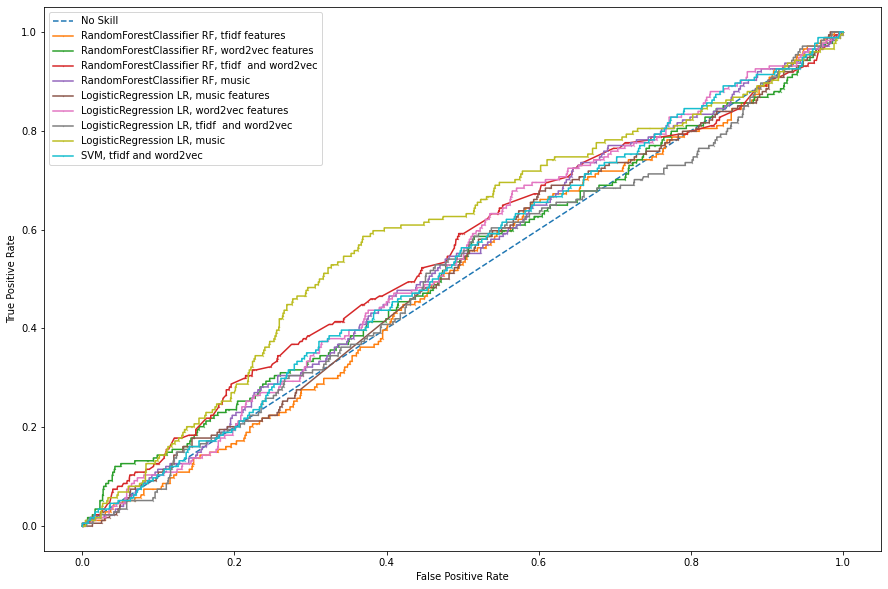

In [50]:
#drawing roc curve and auc


from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

## plot the roc curve: start with no skill prediction
fig, ax = plt.subplots(figsize=(15, 10))
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')


#draw roc curves for tuned models
def draw_roc_curve(model, label):
    model_name=type(model[0]).__name__
    # retrieve roc auc scores
    auc = model[1]
    # calculate roc curves
    # get tpr, fpr
    fpr=model[2]
    tpr=model[3]
    print('Model=%s; Data=%s; ROC AUC=%.3f' % (model_name, label, auc)) 
    lab=model_name+" "+label
    plt.plot(fpr, tpr, marker='.', label=lab, markersize=0.6)

    
model_dict={'RF, tfidf features':rf_fit_tfidf, 'RF, word2vec features': rf_fit_wv, 'RF, tfidf  and word2vec': rf_fit_alltext,'RF, music': rf_fit_music,'LR, music features':lr_fit_tfidf, 'LR, word2vec features': lr_fit_wv, 'LR, tfidf  and word2vec': lr_fit_alltext, 'LR, music': lr_fit_music}



#Draw graphs in a loop
for k,v in model_dict.items():
    draw_roc_curve(v,k)

#add svm
fpr, tpr, _ = roc_curve(y_test, svm_probs)
plt.plot(fpr, tpr, marker='.', markersize=0.6, label="SVM, tfidf and word2vec")
print("Model=SupportVectorMachines; Data=SVM, tfidf and word2vec; ROC AUC= ", roc_auc)    
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
